Szymon Rogowski (405244)
Laboratorium 4

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

print("Libs loaded.")

Libs loaded.


1. Zaszumiony obraz tworzony powstaje przez dodawanie szumu do oryginalnego obrazu. Zakłada się, że szum jest nieskorelowany z obrazem dla każdej współrzędnej. Średnia wartość szumu wynosi zero. Zmniejszenie zawartości szumu można przeprowadzić przez uśrednienie wielu obrazów zaszumionych. Im więcej obrazów zaszumionych zostanie wziętych do obliczenia średniej, tym bardziej szum w każdym pikselu zmniejsza się. Utwórz serię zaszumionych obrazów korzystając z funkcji np. imnoise. Do obrazu oryginalnego dodaj szum gaussowski o następujących parametrach:

- średnia wartość szumu 0, odchyleniu standardowe 20 poziomów szarości

- średnia wartość szumu 0, odchylenie standardowe 40 poziomów szarości

Uśrednij 8, 16, 32 i 64 zaszumione obrazy dla podanych powyższych parametrów szumu. Oblicz różnicę obrazu oryginalnego i średnich obrazów a następnie wyświetl tą różnicę jako obraz. Narysuj histogramy tych różnic.

In [4]:
image_hubble_path = "images/hubble.jpg"
image_hubble = cv2.imread(image_hubble_path, cv2.IMREAD_GRAYSCALE)
image_m45_path = "images/m45.jpg"
image_m45 = cv2.imread(image_m45_path, cv2.IMREAD_GRAYSCALE)

In [5]:
def add_gaussian_noise(image, mean, std_dev):
    row, col = image.shape
    gauss = np.random.normal(mean, std_dev, (row, col))
    noisy = image + gauss
    return np.clip(noisy, 0, 255).astype(np.uint8)

def average_images(images):
    return np.mean(images, axis=0).astype(np.uint8)

def generate_noisy_images(original_image, mean_values, std_dev_values, num_images_to_average):
    noisy_images = []
    averaged_images = []
    difference_images = []

    for std_dev in std_dev_values:
        noisy_image_set = [add_gaussian_noise(original_image, mean_values[0], std_dev) for _ in range(max(num_images_to_average))]
        noisy_images.append(noisy_image_set)

        for num_images in num_images_to_average:
            noisy_set = noisy_image_set[:num_images]
            averaged_image = average_images(noisy_set)
            averaged_images.append(averaged_image)
            difference_images.append(original_image - averaged_image)

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(averaged_image, cmap='gray')
            plt.title(f'Difference Image (std={std_dev}, num images={num_images})')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.hist(averaged_image.ravel(), bins=256, range=[0, 256])
            plt.title(f'Histogram (std={std_dev}, num images={num_images})')
            plt.xlabel('Pixel Value - Brightness')
            plt.ylabel('Number of pixels')

            plt.show()


In [13]:
# noise parameters
mean_values = [0, 0]
std_dev_values = [20, 40]

# number of images to average
num_images_to_average = [5, 150, 300]

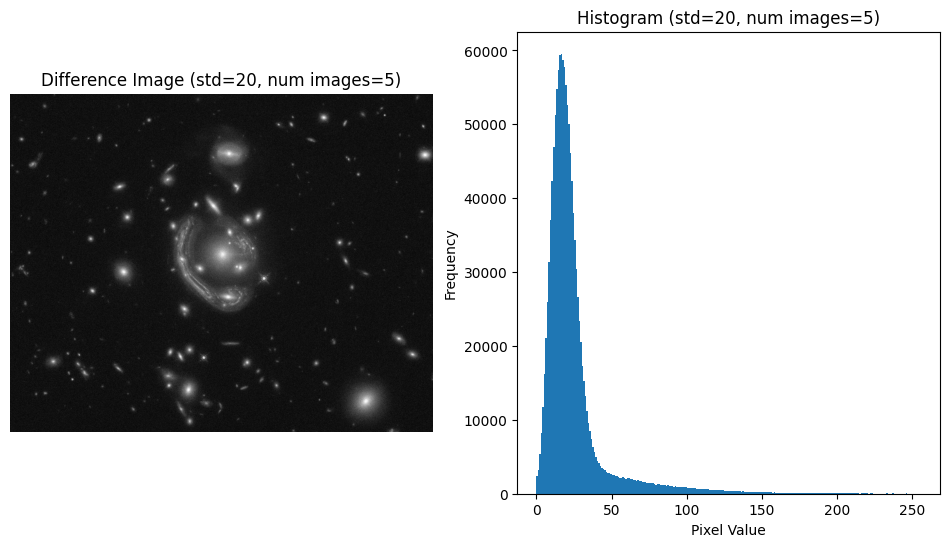

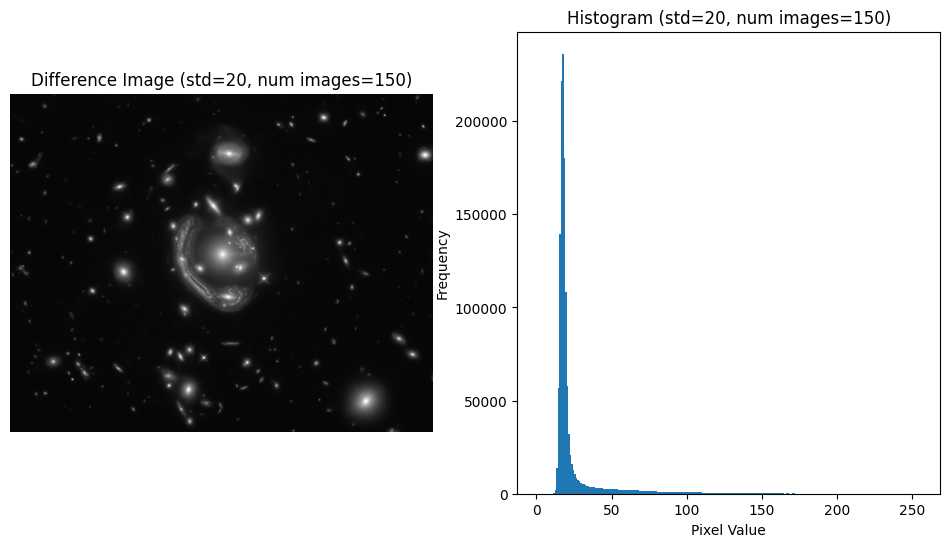

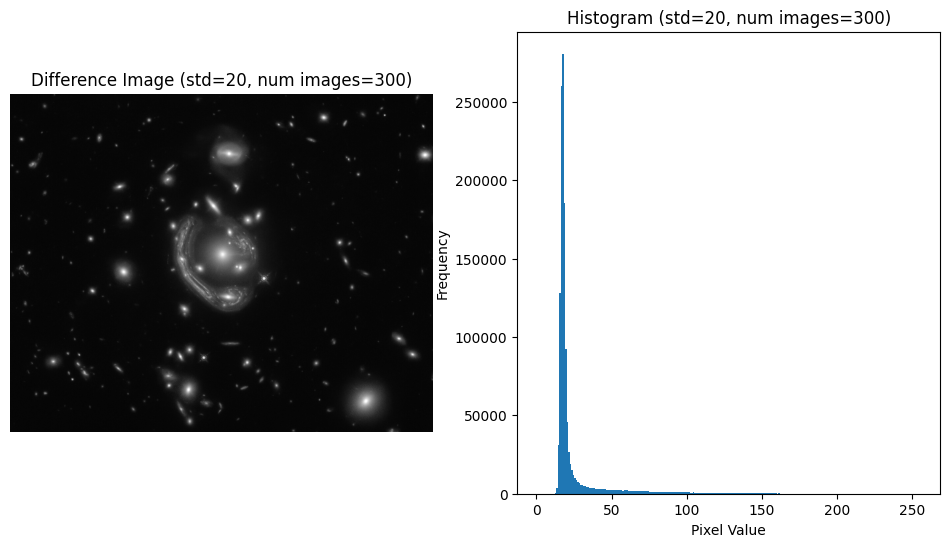

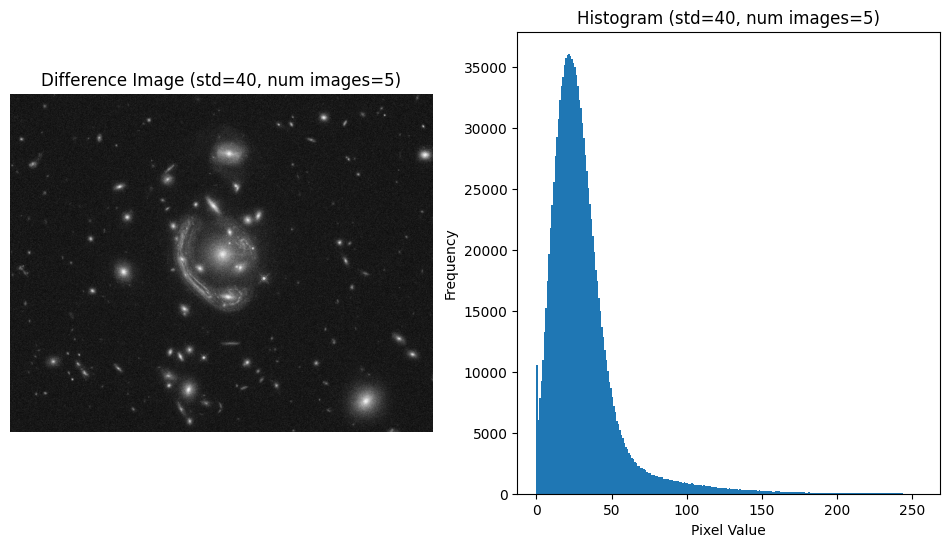

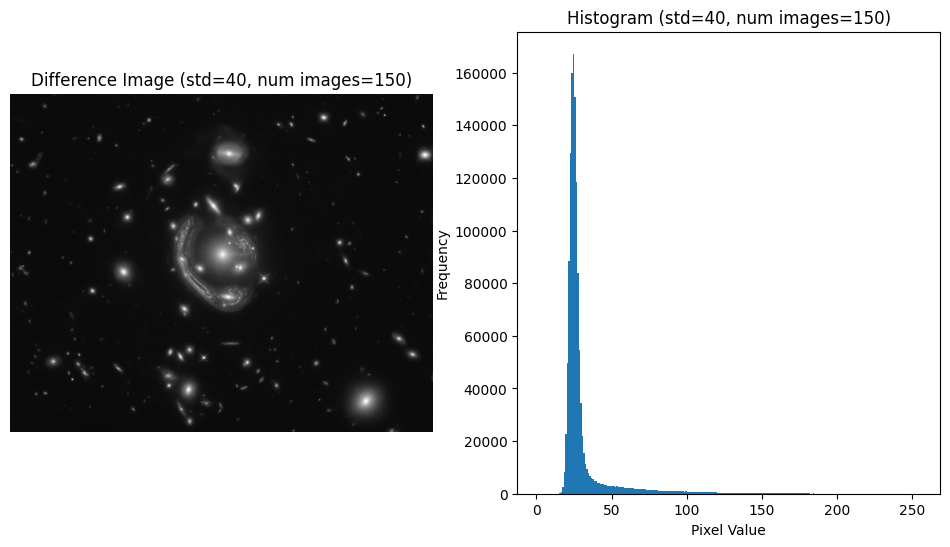

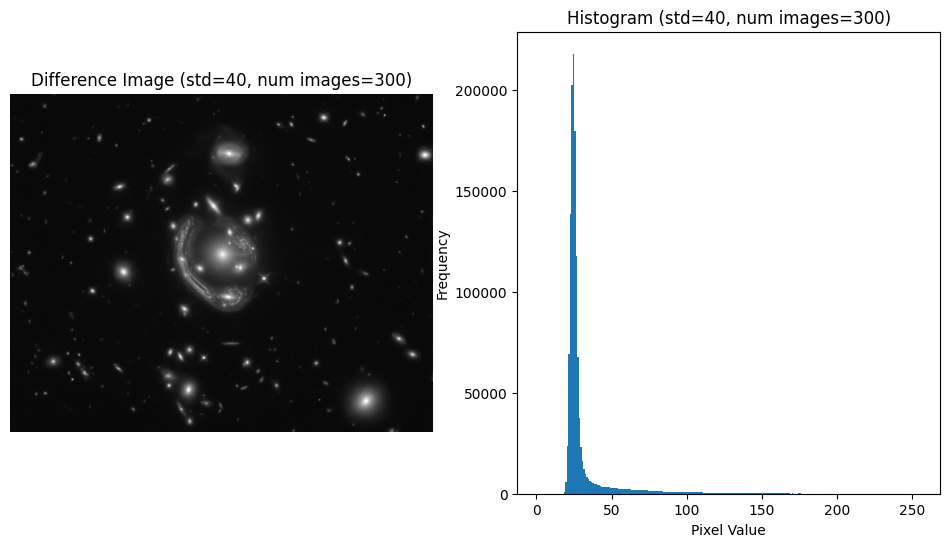

In [14]:
generate_noisy_images(image_hubble, mean_values, std_dev_values, num_images_to_average)

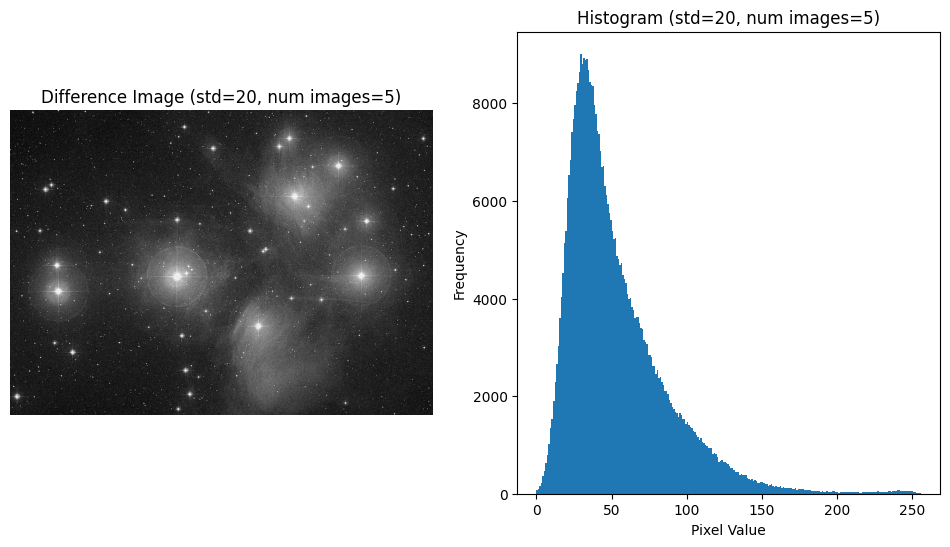

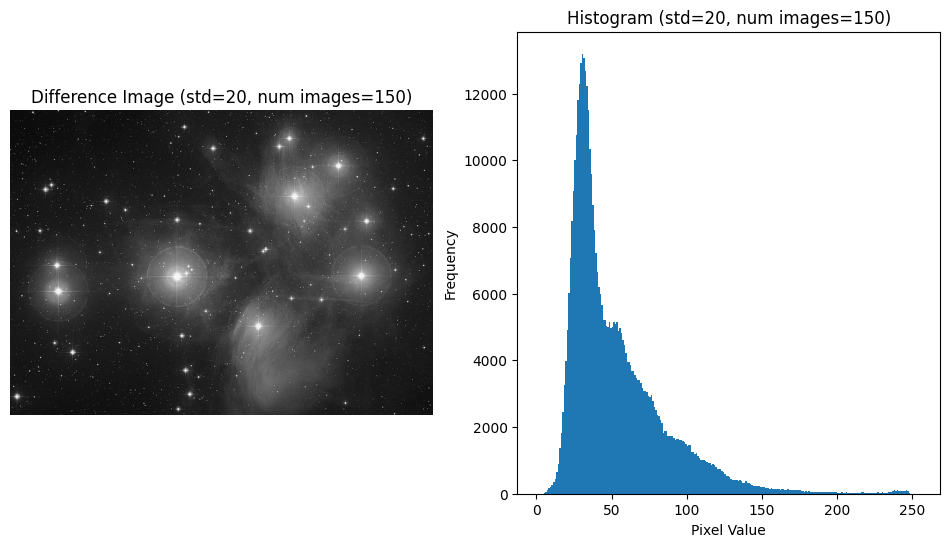

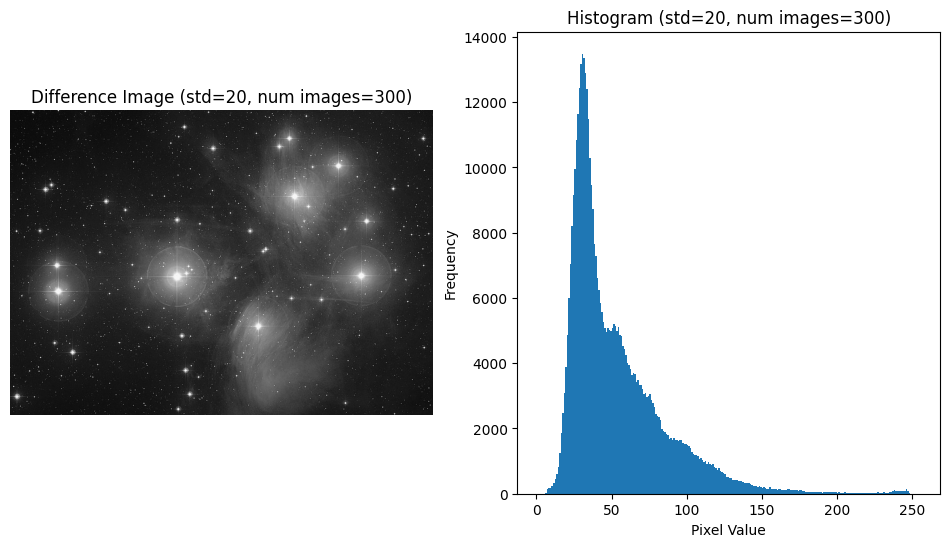

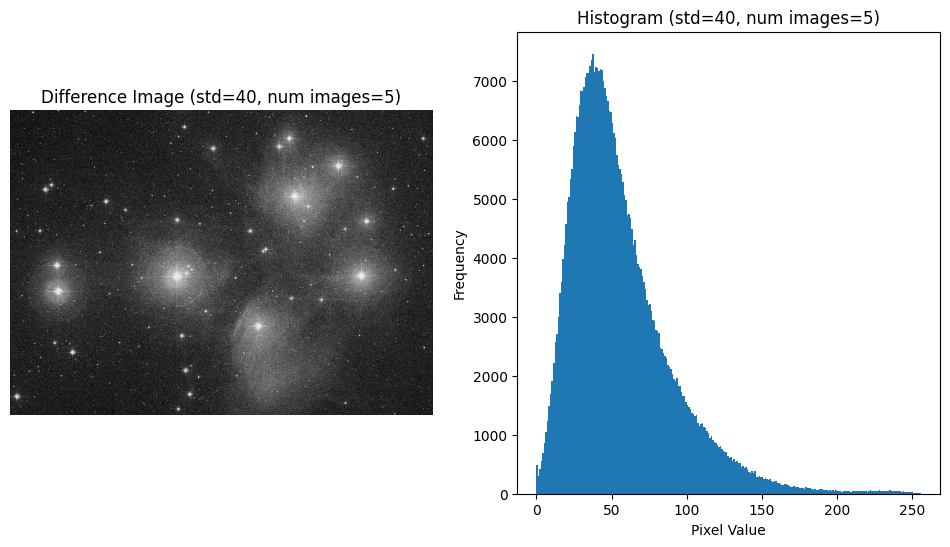

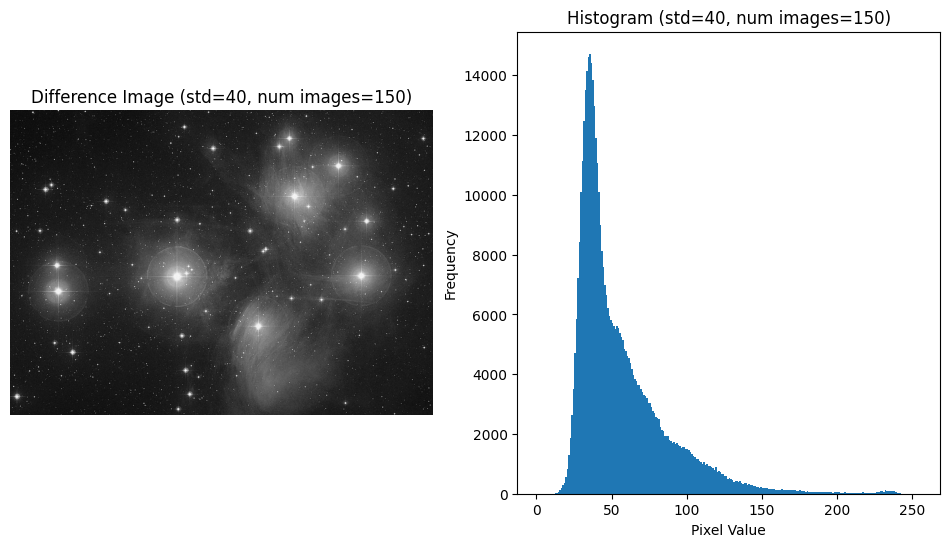

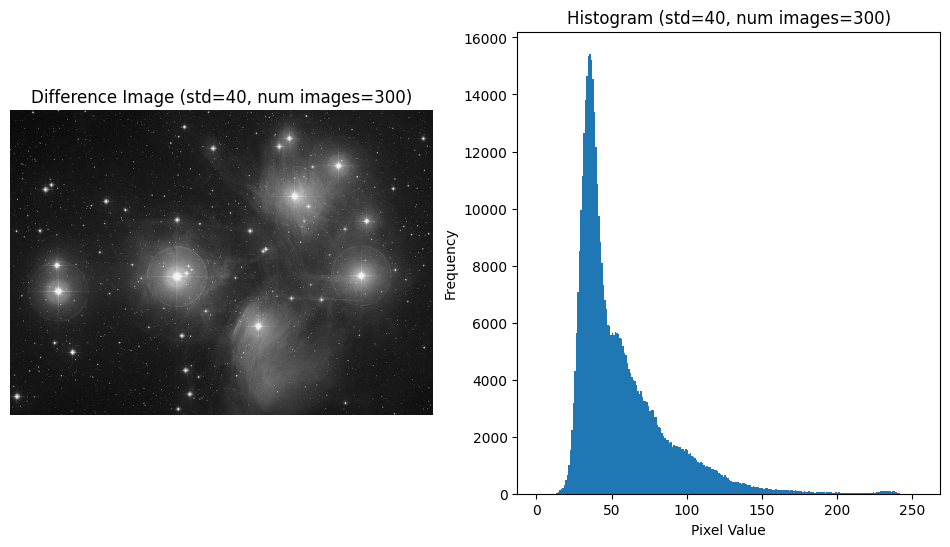

In [15]:
generate_noisy_images(image_m45, mean_values, std_dev_values, num_images_to_average)

Opis i wnioski:
Dodawanie szumu gaussowskiego wpływa na jasność i kontrast obrazu. W miarę zwiększania odchylenia standardowego (std_dev), szum staje się bardziej zauważalny, co prowadzi do bardziej rozmazanych i mniej wyraźnych obrazów.
Obrazy z większym odchyleniem standardowym szumu mają większy kontrast ponieważ natywnie przed przetworzeniem obrazów są one rozrzucone bardziej na ekstremach skali szarości. Daje to większy kontrast na wynikowych obrazach.
Im więcej obrazów jest uśrednianych, tym bardziej wartości pixeli są "średnie", co prowadzi do bardziej skoncentrowanych histogramów. Zwiększa się kontrast, zanikają środkowe spektra skali szarości. Na hisotgramach zwiększa się jasność przy zmniejszeniu rozkładu na osi X - ciemne elementy stają się ciemniejsze a jasne jaśniejsze.
Zgodnie z treścią polecenia uśrednianie obrazów z różnymi poziomami szumu powoduje poprawę jakości obrazu, poprzez zanik poziomu szumów. Im więcej obrazów zostanie uśrednionych, tym bardziej wyraźny staje się rezultat.

2. Szum periodyczny na obrazie można zanalizować w dziedzinie częstotliwości. Szum periodyczny pojawia się w widmie częstotliwości jako skoncentrowane impulsy energii. Położenie tych impulsów odpowiada częstotliwościom periodycznego szumu. Przez zastosowanie selektywnego filtra pasmowego lub wycinającego można usunąć szum. Usuń z obrazu szum periodyczny przez filtrowanie w dziedzinie częstotliwości. Zaproponuj filtr w dziedzinie obrazu wykonujący to samo zadanie.

In [16]:
image_moon_path = "images/moon.png"
image_moon = cv2.imread(image_moon_path, cv2.IMREAD_GRAYSCALE)
image_face_path = "images/face.jpg"
image_face = cv2.imread(image_face_path, cv2.IMREAD_GRAYSCALE)

In [29]:
def generate_gaussian_frequency_filter(shape, w, radius_list):
    u, v = np.arange(-shape[1]//2, shape[1]//2),  np.arange(-shape[0]//2, shape[0]//2)
    U, V = np.meshgrid(u, v)
    D = np.sqrt(U**2 + V**2)
    H = 1
    for radius in radius_list:
        H_helper = 1 - np.exp(-0.5 * (((D**2 - radius**2) / (D * w)) ** 2))
        H *= H_helper
    return H

def apply_filter(img, width, radius_list):
    f_img = np.fft.fft2(img)
    f_shift = np.fft.fftshift(f_img)
    r, c = img.shape
    filter = generate_gaussian_frequency_filter((r, c), width, radius_list)

    f_result = f_shift * filter
    result_image = np.abs(np.fft.ifft2(np.fft.ifftshift(f_result)))

    plt.figure(figsize=(12, 6))

    plt.subplot(131), plt.imshow(img, cmap='gray')
    plt.title('Input'), plt.xticks([]), plt.yticks([])

    plt.subplot(132), plt.imshow(np.log(np.abs(f_shift) + 1) + np.log(np.abs(filter) + 1), cmap='gray')
    plt.title('Spectrum with applied Mask'), plt.xticks([]), plt.yticks([])

    plt.subplot(133), plt.imshow(result_image, cmap='gray')
    plt.title('After gaussian filter'), plt.xticks([]), plt.yticks([])

    plt.show()

C:\Users\szymo\AppData\Local\Temp\ipykernel_25116\1985092115.py:7: RuntimeWarning: divide by zero encountered in divide
  H_helper = 1 - np.exp(-0.5 * (((D**2 - radius**2) / (D * w)) ** 2))


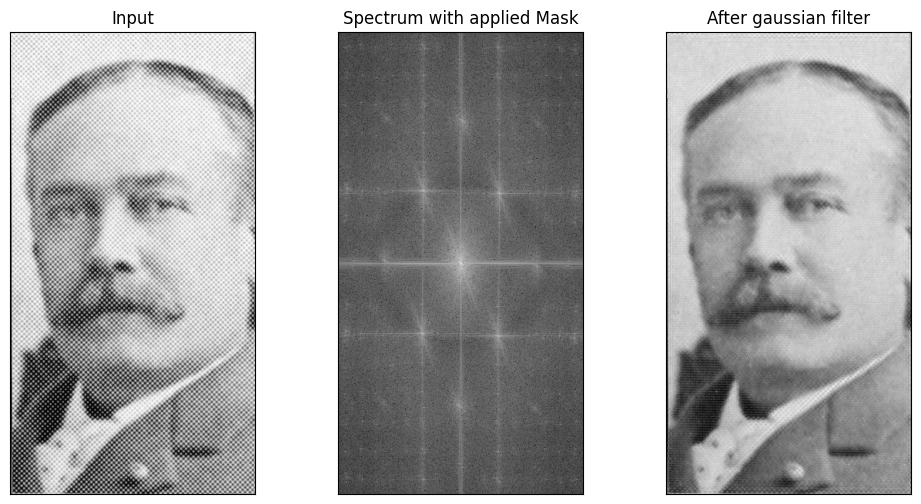

In [30]:
width = 22
radius_list = [105]
apply_filter(image_face, width, radius_list)

C:\Users\szymo\AppData\Local\Temp\ipykernel_25116\1985092115.py:7: RuntimeWarning: divide by zero encountered in divide
  H_helper = 1 - np.exp(-0.5 * (((D**2 - radius**2) / (D * w)) ** 2))


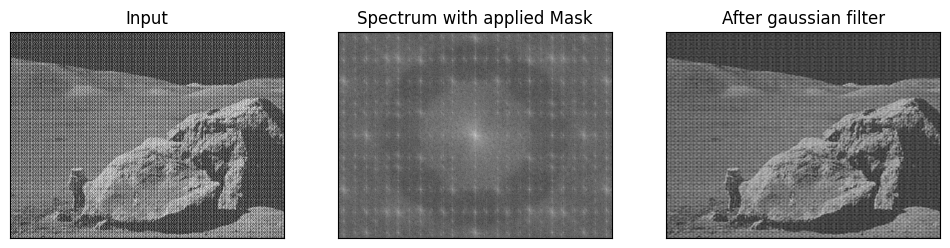

In [31]:
width = 22
radius_list = [138, 150, 160, 170, 180, 190, 200]
apply_filter(image_moon, width, radius_list)

Widmo częstotliwościowe obrazu to reprezentacja amplitud i faz poszczególnych częstotliwości obecnych w obrazie.
Aby przenieść obraz do przestrzeni częstotliwości użyta została już poznana transformata Fouriera, i jej odwrotność aby przenieść obraz do dziedziny obrazów. Kolejno używana jest maska, która ma na celu wyfiltrowanie określonych częstotliwości z widma obrazu, jest to maska, filtr Gaussa, używany do wygładzania obrazów. Potem widmo zostaje dodane do maski poprzez zastosowanie maski do widma częstotliwościowego. Oznacza to mnożenie amplitud poszczególnych częstotliwości z widma przez odpowiadające wartości w masce.
Ten krok jest wykonywany, aby uzyskać zfiltrowane widmo, które pokazuje, które częstotliwości są zachowane, a które są eliminowane przez filtr.
W obu przypadkach widać znaczną poprawę, zwłaszcza na zdjęciu numer 1, twarzy mężczyzny.
Filtr wpływa na obraz poprzez eliminacje pewnych częstotliwości i poprawiając ogólną jakość obrazu, dla konkretnych parametrów, takich jak szerokość czy promień. Na drugim spektrum widocznych jest więcej skupień szumu, starałem sie w obu przypadkach aby te promienie przechodziły przez właśnie te skupienia. Natomiast oczywiście najlepiej by to wyliczyć dla idealnych rezultatów, zwłaszcza w przypadku numer 2.